In [20]:
import numpy as np
import matplotlib.pyplot as plt

In [21]:
from pathlib import Path
import sys

try:
    ROOT = Path().resolve().parents[1]
    assert (ROOT / "common").exists()
except AssertionError:
    ROOT = next(p for p in Path().resolve().parents if (p / "common").exists())

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

In [22]:
#print(ROOT)

In [23]:
from common import sensors as sn 
from common import em_tools as em
from common import log_funcs as lf

In [24]:
wave_length = 1.5
inter_sensor_dist = 0.75
DIST_RATIO = inter_sensor_dist / wave_length

Num_sensors = 1000
Num_emitters = 1
sample_size = 50

failing_sensors = np.arange(500, 1000)
gap_ratio = 0.5 * np.ones_like(failing_sensors, dtype=np.float32)

theta_rad = np.array([0.7]) # Угловые координаты источников (DoA) в радианах
theta_deg = np.rad2deg(theta_rad) # Угловые координаты источников (DoA) в градусах

signal_pressure = 0.01
noise_pressure = 0.0016

# Расстояния между источником и антенной решеткой, два случая
emitter_receiver_distance1 = 100
emitter_receiver_distance2 = 1000

P1 = (sn.signal_variance(signal_pressure, emitter_receiver_distance1) * 
      np.eye(Num_emitters, dtype=np.float64)) # Ковариация сигналов для ближнего источника
P2 = (sn.signal_variance(signal_pressure, emitter_receiver_distance2) * 
      np.eye(Num_emitters, dtype=np.float64)) # Ковариация сигналов для дальнего источника

Q = sn.noise_variance(signal_pressure) * np.eye(Num_sensors, dtype=np.float64) # Ковариация шумов

A = (np.exp(-2j * np.pi * DIST_RATIO * np.arange(Num_sensors).reshape(-1,1) * 
             np.sin(theta_rad))) # Матрица векторов направленности

# Генерация сигналов, шумов и наблюдений
N = sn.gss(Num_sensors, sample_size, Q)

S1 = sn.gss(Num_emitters, sample_size, P1)
S2 = sn.gss(Num_emitters, sample_size, P2)

X1 = (A @ S1.T + N.T).T
X2 = (A @ S2.T + N.T).T

X1_with_mv = sn.MCAR(X1, failing_sensors, gap_ratio)
X2_with_mv = sn.MCAR(X2, failing_sensors, gap_ratio)

theta_guess = 0.95 * theta_rad

In [25]:
print(f"theta_rad={theta_rad}, theta_deg={theta_deg}")
print(f"P1={P1}")
print(f"P2={P2}")

theta_rad=[0.7], theta_deg=[40.10704566]
P1=[[1.e-08]]
P2=[[1.e-10]]


In [26]:
print(f"first SNR = {sn.SNR(A, P1, Q, metrics = 'avg', scale = 'linear')}")
print(f"second SNR = {sn.SNR(A, P2, Q, metrics = 'avg', scale = 'linear')}")

first SNR = 0.1
second SNR = 0.0009999999999999998


In [27]:
EM_theta1_rad, EM_P1, lhd_1, lhd_list1, angles_list1 = em.multistart_EM(X1_with_mv, 
                                                                        Num_emitters, 
                                                                        Q=Q,
                                                                        theta_guess=theta_guess, 
                                                                        num_of_starts=1, 
                                                                        max_iter=25, 
                                                                        rtol_params=1e-6,
                                                                        rtol_lkhd=1e-9,
                                                                        reg_coef=1e-12)

0-th start
theta=[0.665],P=[[9.65050555e-10+0.j]]
Inital likelihood = 307869.56528320996
Iteration=1
new_angles=[0.665]
new_P:
[[3.0584585e-10+0.j]]
likelihood is 307869.5924439999 on iteration 1.
Iteration=2
new_angles=[0.665]
new_P:
[[3.07396767e-10+0.j]]
likelihood is 307869.59238121123 on iteration 2.
Likelihood is converged!
best_start=0
Время выполнения функции: 144.195954 секунд


In [28]:
EM_theta1_rad, EM_P1

(array([0.665]), array([[3.0584585e-10+0.j]]))

In [29]:
lf.incomplete_lkhd(X1_with_mv, EM_theta1_rad, EM_P1, Q), lf.incomplete_lkhd(X1_with_mv, theta_rad, P1, Q)

(np.float64(307869.5924439999), np.float64(307869.858296802))

In [30]:
lhd_list1 = np.array(lhd_list1)
x1_lhd = np.arange(1, len(lhd_list1)+1)

angles_list1 = np.rad2deg(np.array(angles_list1))
x1_angle = np.arange(len(angles_list1))

In [31]:
EM_theta2_rad, EM_P2, lhd_2, lhd_list2, angles_list2 = em.multistart_EM(X2_with_mv, 
                                                                        Num_emitters, 
                                                                        Q=Q,
                                                                        theta_guess=theta_guess,
                                                                        num_of_starts=1, 
                                                                        max_iter=25, 
                                                                        rtol_params=1e-6,
                                                                        rtol_lkhd=1e-9,
                                                                        reg_coef=1e-12)

0-th start
theta=[0.665],P=[[9.65050555e-10+0.j]]
Inital likelihood = 307869.07585070585
Iteration=1
new_angles=[0.665]
new_P:
[[3.05868167e-10+0.j]]
likelihood is 307869.10269485274 on iteration 1.
Iteration=2
new_angles=[0.665]
new_P:
[[3.07420965e-10+0.j]]
likelihood is 307869.10263273516 on iteration 2.
Likelihood is converged!
best_start=0
Время выполнения функции: 181.152847 секунд


In [32]:
EM_theta2_rad, EM_P2

(array([0.665]), array([[3.05868167e-10+0.j]]))

In [33]:
lf.incomplete_lkhd(X2_with_mv, EM_theta2_rad, EM_P2, Q), lf.incomplete_lkhd(X2_with_mv, theta_rad, P2, Q)

(np.float64(307869.10269485274), np.float64(307869.1192573581))

In [34]:
lhd_list2 = np.array(lhd_list2)
x2_lhd = np.arange(1, len(lhd_list2)+1)

angles_list2 = np.rad2deg(np.array(angles_list2))
x2_angle = np.arange(len(angles_list2))

x_grid = np.arange(1,26,5)

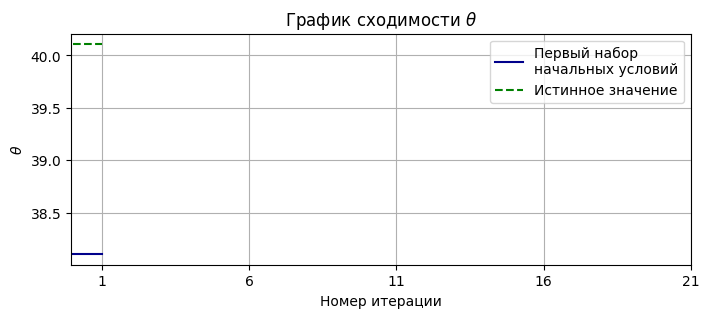

In [35]:
plt.figure(figsize=(8, 3))
plt.title(r'$\text{График сходимости} \,\,\theta$')
plt.plot(x1_angle, angles_list1,color='darkblue', label=f'Первый набор\nначальных условий')
plt.plot(x1_angle, np.tile(theta_deg, len(angles_list1)), color='green', label='Истинное значение', linestyle='--')
plt.xlabel('Номер итерации') 
plt.ylabel(r'$\theta$')
plt.xticks(x_grid)
plt.legend()
plt.grid()
plt.show()

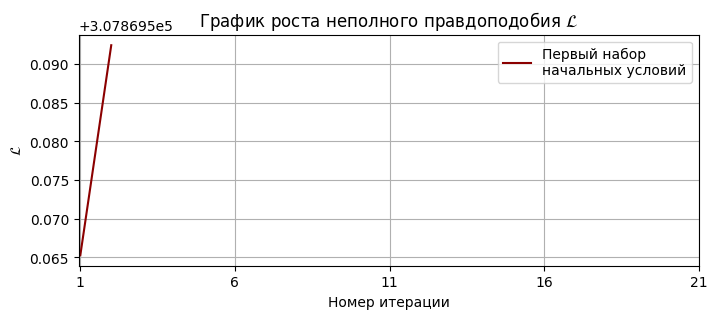

In [36]:
plt.figure(figsize=(8, 3))
plt.title(r'$\text{График роста неполного правдоподобия} \,\,\mathcal{L}$')
plt.plot(x1_lhd, lhd_list1,color='darkred', label=f'Первый набор\nначальных условий')
plt.xlabel('Номер итерации') 
plt.ylabel(r'$\mathcal{L}$')
plt.xticks(x_grid)
plt.legend()
plt.grid()
plt.show()

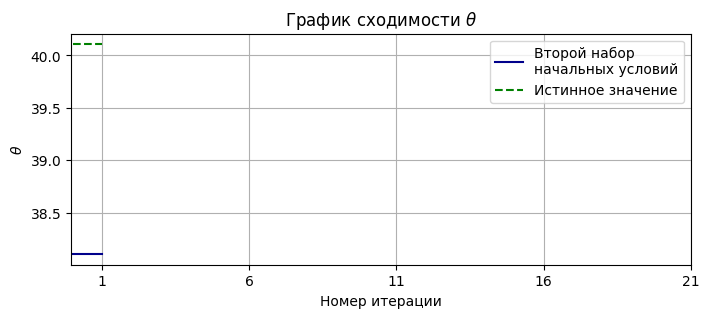

In [37]:
plt.figure(figsize=(8, 3))
plt.title(r'$\text{График сходимости} \,\,\theta$')
plt.plot(x2_angle, angles_list2,color='darkblue', label=f'Второй набор\nначальных условий')
plt.plot(x2_angle, np.tile(theta_deg, len(angles_list2)), color='green', label='Истинное значение', linestyle='--')
plt.xlabel('Номер итерации') 
plt.ylabel(r'$\theta$')
plt.xticks(x_grid)
plt.legend()
plt.grid()
plt.show()

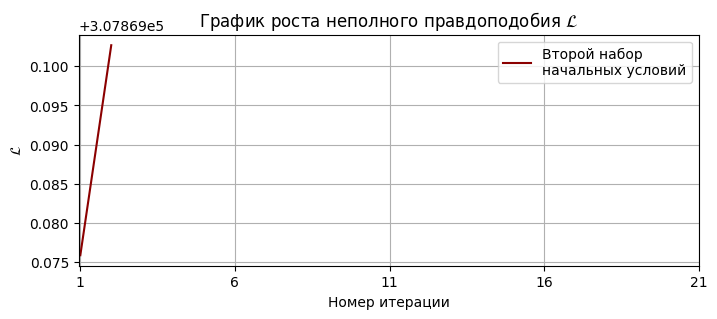

In [38]:
plt.figure(figsize=(8, 3))
plt.title(r'$\text{График роста неполного правдоподобия} \,\,\mathcal{L}$')
plt.plot(x2_lhd, lhd_list2,color='darkred', label=f'Второй набор\nначальных условий')
plt.xlabel('Номер итерации') 
plt.ylabel(r'$\mathcal{L}$')
plt.xticks(x_grid)
plt.legend()
plt.grid()
plt.show()